In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
import os
import gc
import json
from scipy.optimize import curve_fit
import datetime
from pathlib import Path

import plotly.express as px
from urllib.request import urlopen



In [8]:
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 50)

In [9]:
df = pd.read_csv('https://query.data.world/s/keax53lpqwffhayvcjmowjiydtevwo', parse_dates=['REPORT_DATE']).copy()


In [10]:
df.head()

,PEOPLE_POSITIVE_CASES_COUNT,COUNTY_NAME,PROVINCE_STATE_NAME,REPORT_DATE,CONTINENT_NAME,DATA_SOURCE_NAME,PEOPLE_DEATH_NEW_COUNT,COUNTY_FIPS_NUMBER,COUNTRY_ALPHA_3_CODE,COUNTRY_SHORT_NAME,COUNTRY_ALPHA_2_CODE,PEOPLE_POSITIVE_NEW_CASES_COUNT,PEOPLE_DEATH_COUNT
0,1043,NaN,Nova Scotia,2020-05-18,America,Public Health Agency of Canada,0,nan,CAN,Canada,CA,3,55
1,8,NaN,Saskatchewan,2020-03-20,America,Public Health Agency of Canada,0,nan,CAN,Canada,CA,0,0
2,0,NaN,Nunavut,2020-06-22,America,Public Health Agency of Canada,0,nan,CAN,Canada,CA,0,0
3,0,NaN,Nunavut,2020-09-10,America,Public Health Agency of Canada,0,nan,CAN,Canada,CA,0,0
4,261,NaN,Newfoundland and Labrador,2020-06-16,America,Public Health Agency of Canada,0,nan,CAN,Canada,CA,0,3


In [11]:
print("date range: {0} to {1}".format(df['REPORT_DATE'].min(), df['REPORT_DATE'].max()))

date range: 2019-12-31 00:00:00 to 2020-10-17 00:00:00


In [12]:
print(df.columns)

Index(['PEOPLE_POSITIVE_CASES_COUNT', 'COUNTY_NAME', 'PROVINCE_STATE_NAME',
       'REPORT_DATE', 'CONTINENT_NAME', 'DATA_SOURCE_NAME',
       'PEOPLE_DEATH_NEW_COUNT', 'COUNTY_FIPS_NUMBER', 'COUNTRY_ALPHA_3_CODE',
       'COUNTRY_SHORT_NAME', 'COUNTRY_ALPHA_2_CODE',
       'PEOPLE_POSITIVE_NEW_CASES_COUNT', 'PEOPLE_DEATH_COUNT'],
      dtype='object')


# US Trends

In [13]:
df_us = df[df['COUNTRY_ALPHA_2_CODE'] == 'US'].copy()

In [14]:
df_us['PROVINCE_STATE_NAME'].unique()

array(['Alabama', 'Georgia', 'Mississippi', 'Maine', 'Indiana', 'Ohio',
       'Nebraska', 'Wisconsin', 'California', 'Texas', 'Idaho',
       'Kentucky', 'Arkansas', 'Iowa', 'South Carolina', 'Tennessee',
       'Hawaii', 'Michigan', 'Virginia', 'Florida', 'Washington',
       'Kansas', 'North Dakota', 'West Virginia', 'Illinois', 'Missouri',
       'Montana', 'Minnesota', 'Alaska', 'Arizona', 'New Jersey',
       'Pennsylvania', 'New York', 'Wyoming', 'Vermont', 'Louisiana',
       'North Carolina', 'South Dakota', 'Nevada', 'Colorado', 'Oregon',
       'Oklahoma', 'Utah', 'New Mexico', 'Connecticut', 'New Hampshire',
       'Rhode Island', 'Delaware', 'District of Columbia', 'Maryland',
       'Massachusetts'], dtype=object)

In [15]:
df_usp = df_us.groupby(['REPORT_DATE','PROVINCE_STATE_NAME']).sum()[
    [
        'PEOPLE_POSITIVE_CASES_COUNT', 
        'PEOPLE_POSITIVE_NEW_CASES_COUNT', 
        'PEOPLE_DEATH_COUNT', 
        'PEOPLE_DEATH_NEW_COUNT'
    ]
]
df_usp['MORTALITY_RATIO'] = df_usp['PEOPLE_DEATH_COUNT']/df_usp['PEOPLE_POSITIVE_CASES_COUNT']
df_usp = df_usp.unstack().copy().drop('District of Columbia', level=1, axis=1)

In [16]:
top_10 = df_usp.xs('PEOPLE_DEATH_COUNT', axis=1, level=0).iloc[-1].sort_values(ascending=False)[0:10].index.values
top_25 = df_usp.xs('PEOPLE_DEATH_COUNT', axis=1, level=0).iloc[-1].sort_values(ascending=False)[0:25].index.values

In [17]:
print("Total deaths to date:\n{0}".format(df_usp.xs('PEOPLE_DEATH_COUNT', axis=1, level=0).iloc[-1][top_25]))

Total deaths to date:
PROVINCE_STATE_NAME
New York          32944
Texas             17454
California        16919
New Jersey        16202
Florida           15829
Massachusetts      9702
Illinois           9447
Pennsylvania       8524
Georgia            7382
Michigan           7320
Arizona            5806
Louisiana          5727
Ohio               5054
Connecticut        4542
Maryland           4032
North Carolina     3938
Indiana            3887
South Carolina     3615
Virginia           3408
Mississippi        3160
Tennessee          2847
Alabama            2786
Missouri           2550
Washington         2338
Minnesota          2265
Name: 2020-10-16 00:00:00, dtype: int64


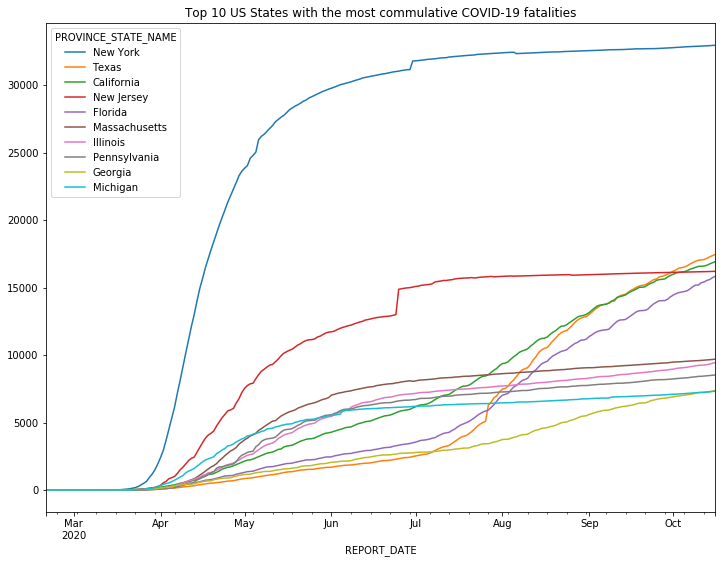

In [18]:
df_usp.xs('PEOPLE_DEATH_COUNT', axis=1, level=0).iloc[30::][top_10].plot.line(
    figsize=(12,9),
    title="Top 10 US States with the most commulative COVID-19 fatalities"
);

The graphs below show the growth trends by state.  Note that the left axis is not standardized between states so it's important to look at the magnitude.

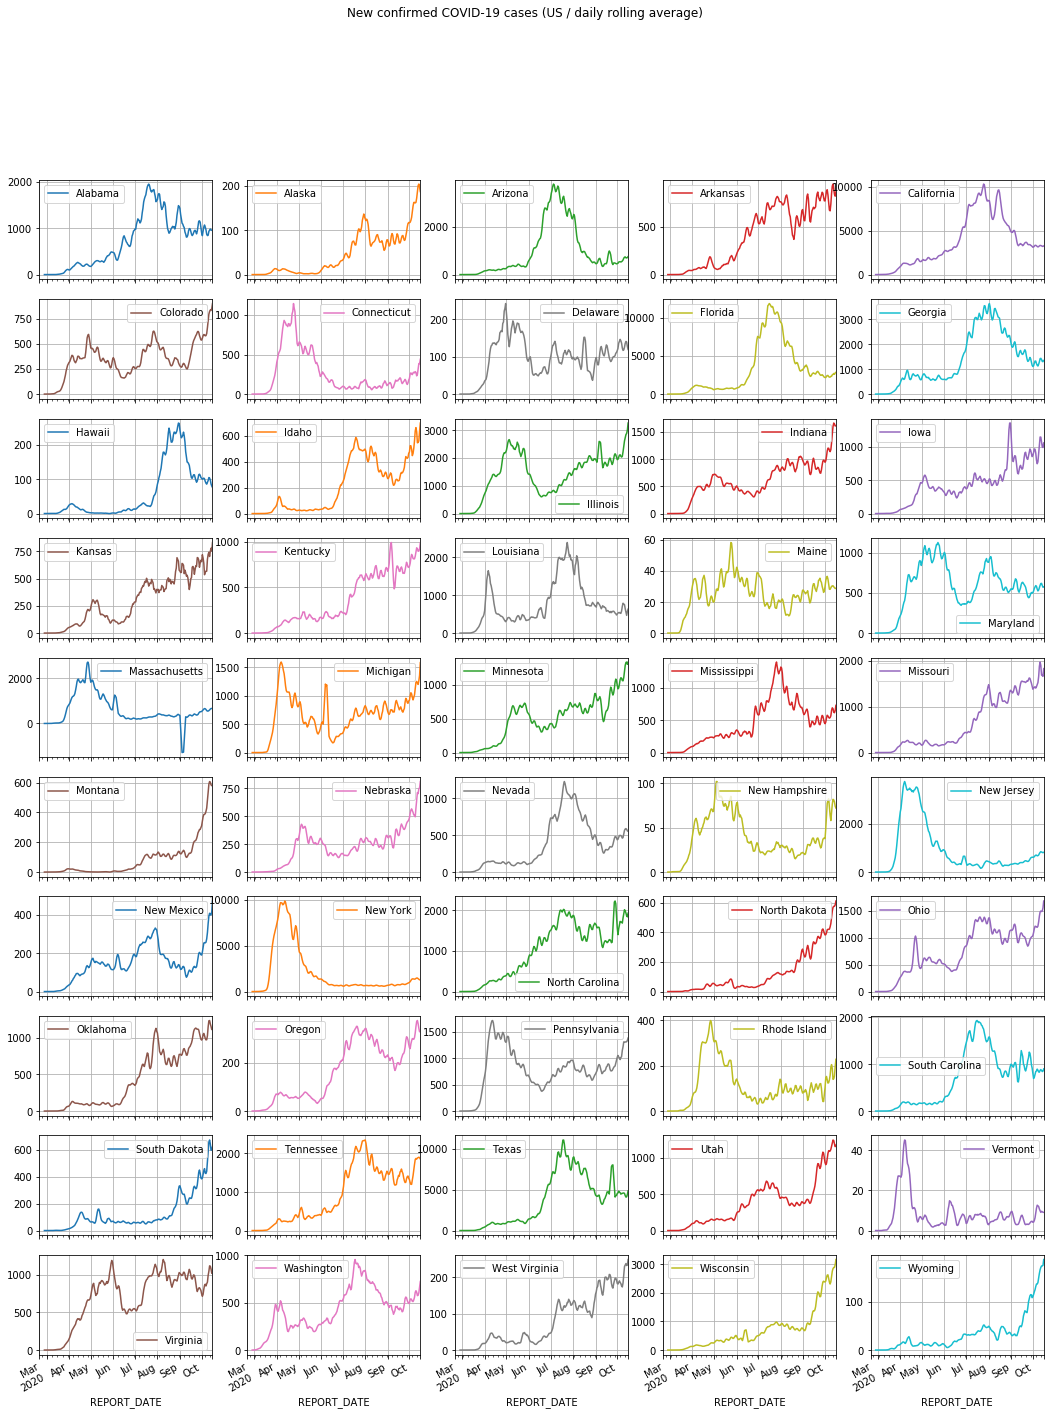

In [19]:
df_usp.xs('PEOPLE_POSITIVE_CASES_COUNT', axis=1, level=0).iloc[30::].rolling(window=5).mean().diff().rolling(3).mean().plot(
    subplots=True, 
#     ylim=(-10,25), 
    layout=(10,5), 
    figsize=(18,24),
    grid=True, 
    title='New confirmed COVID-19 cases (US / daily rolling average)',
);
plt.savefig('./out/covid_cases_us_trends.png');

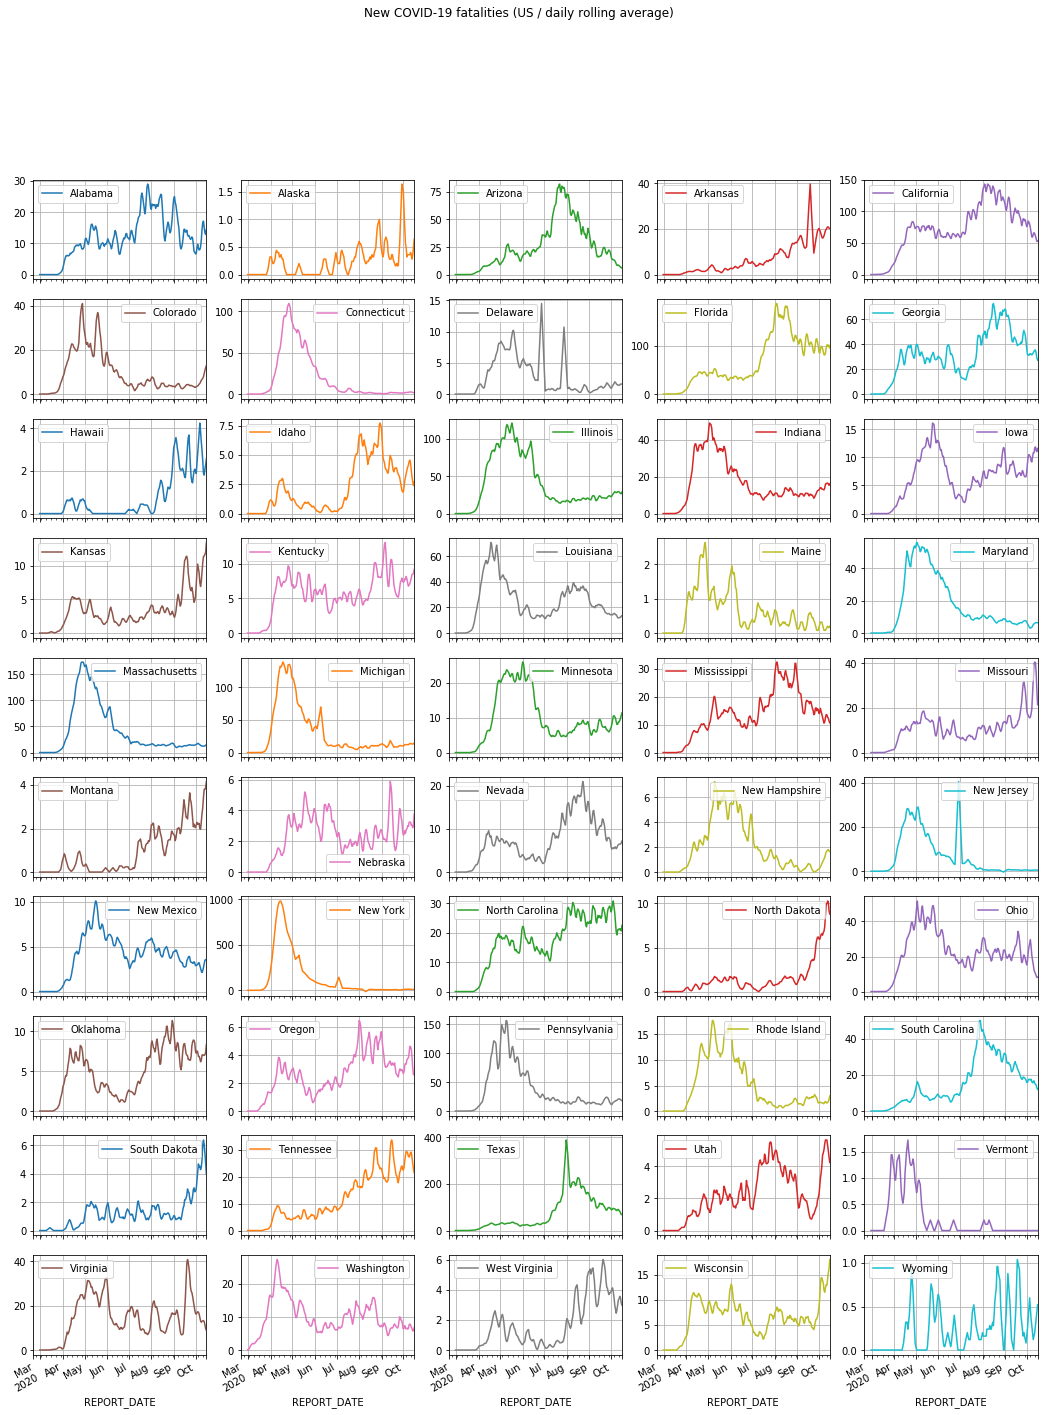

In [20]:
df_usp.xs('PEOPLE_DEATH_COUNT', axis=1, level=0).iloc[30::].rolling(window=5).mean().diff().rolling(5).mean().plot(
    subplots=True, 
#     ylim=(-10,25), 
    layout=(10,5), 
    figsize=(18,24),
    grid=True, 
    title='New COVID-19 fatalities (US / daily rolling average)',
);
plt.savefig('./out/covid_deaths_us_trends.png');

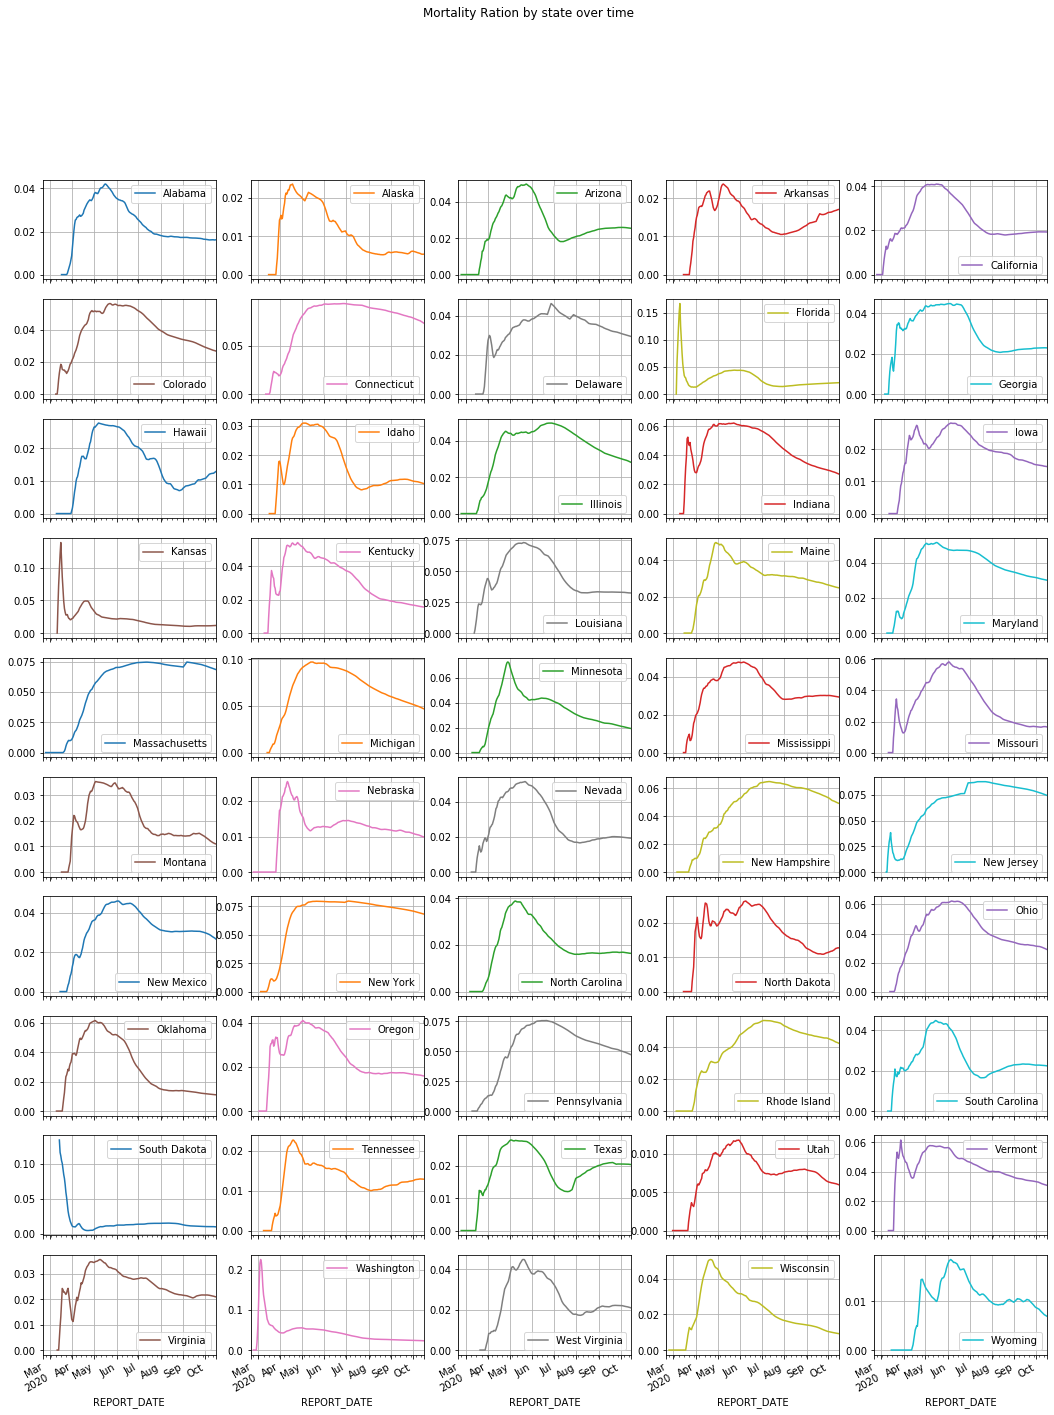

In [21]:
df_usp.xs('MORTALITY_RATIO', axis=1, level=0).iloc[30::].rolling(window=5).mean().plot(
    subplots=True, 
#     ylim=(-10,25), 
    layout=(10,5), 
    figsize=(18,24),
    grid=True, 
    title='Mortality Ration by state over time',
);

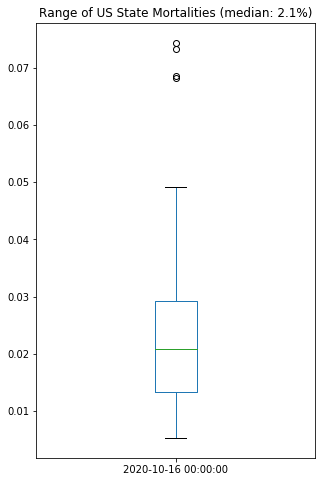

In [25]:
df_usp.xs('MORTALITY_RATIO', axis=1, level=0).iloc[30::].rolling(window=5).mean().iloc[-1].plot.box(
    figsize=(5,8),
    title="Range of US State Mortalities (median: {0:0.1f}%)".format(np.median(df_usp.xs('MORTALITY_RATIO', axis=1, level=0).iloc[30::].rolling(window=5).mean().iloc[-1].fillna(0).values)*100)
);